# Introduction

Steps I followed
- Understand your data, check distributions
- **Create a good Baseline**
- Improve using Model
- Inspect Model
- Iterate

# Imports and Reading Data

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np_utils
%matplotlib inline
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, concatenate, LeakyReLU
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout1D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from data_science_utils.vision.keras import *
from time import time
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno as msno
import re
from joblib import Parallel, delayed
from data_science_utils import dataframe as df_utils
from data_science_utils import models as model_utils
from data_science_utils import plots as plot_utils
from data_science_utils.dataframe import column as column_utils
from data_science_utils import misc as misc
from data_science_utils import preprocessing as pp_utils
from data_science_utils import nlp as nlp_utils

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from data_science_utils.dataframe import get_specific_cols
from random import sample

import more_itertools
from more_itertools import flatten
import ast
from sklearn.preprocessing import LabelEncoder

import gc
from sklearn.decomposition import PCA

import sys
import os
sys.path.append(os.getcwd())
from importlib import reload
import lib_research
reload(lib_research)
from lib_research import *

import warnings
warnings.filterwarnings('ignore')

reload(model_utils)
from data_science_utils.models import mean_absolute_percentage_error
from data_science_utils.models import median_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
from more_itertools import flatten
import dill
from collections import Counter
import operator


Using TensorFlow backend.
[nltk_data] Downloading package punkt to /Users/ahemf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ahemf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ahemf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ahemf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to /Users/ahemf/nltk_data...
[nltk_data]   Package omw is already up-to-date!


# Data Preprocessing


In [2]:
jobs=2

In [ ]:
df = pd.read_csv("price_prediction/india-asins.csv")
df = preprocess_for_word_cnn(df,jobs=jobs)
df.to_csv("price_prediction/india-asins.csv",index=False)


In [ ]:
df = pd.read_csv("price_prediction/india-asins.csv")
df["text"] = Parallel(n_jobs=jobs, backend="loky")(delayed(ast.literal_eval)(x) for x in tqdm(df["text"].values))
df_train,df_test = train_test_split(df,test_size=0.2)

In [3]:
# Read Data
df_train = pd.read_csv("price_prediction/india-asins-train.csv")
df_test = pd.read_csv("price_prediction/india-asins-test.csv")

In [5]:


# Text Encoding
df_train = preprocess_for_word_cnn(df_train,jobs=jobs)
le_train,le_transform, le = get_text_le("text",vocab_size=100000)
_ = le_train(df_train)
df_train['text_encoded'] = le_transform(df_train)

df_test = preprocess_for_word_cnn(df_test,jobs=jobs)
df_test['text_encoded'] = le_transform(df_test)

# GL encoding
gl_le_train,gl_le_transform, gl_le = get_le(colname="gl")
_ = gl_le_train(df_train)
df_train['gl_encoded'] = gl_le_transform(df_train)
df_test['gl_encoded'] = gl_le_transform(df_test)

# Save Intermediate Steps
with open("gl_le.save", "wb") as fobj:
    dill.dump(gl_le, fobj)
    
with open("le.save", "wb") as fobj:
    dill.dump(le, fobj)

df_test.columns
df_train.columns
df_test = df_test[["asin","gl","gl_encoded","text","text_encoded","price"]]
df_train = df_train[["asin","gl","gl_encoded","text","text_encoded","price"]]




Total Words before Min frequency filtering 32295
Total Words after Min frequency filtering 8734


Index(['asin', 'price', 'gl', 'text_raw', 'text', 'text_encoded',
       'gl_encoded'],
      dtype='object')

Index(['asin', 'price', 'gl', 'text_raw', 'text', 'text_encoded',
       'gl_encoded'],
      dtype='object')

In [6]:

with open("gl_le.save", "rb") as fobj:
    gl_le = dill.load(fobj)
    
with open("le.save", "rb") as fobj:
    le = dill.load(fobj)
    

In [7]:
glove = api.load("glove-twitter-50") 
ptr_glove = PreTrainedEmbeddingsTransformer(glove,size=50)

In [8]:


df_test['glove_encoded'] = ptr_glove.transform(df_test['text'].values)
df_train['glove_encoded'] = ptr_glove.transform(df_train['text'].values)

Fasttext Transforms start at: 2019-06-28 22:00:29.764264
Number of Unique Test Tokens for Fasttext transform 15756


100%|██████████| 5000/5000 [00:00<00:00, 53360.47it/s]


Fasttext Transforms done at: 2019-06-28 22:00:30.286190
Fasttext Transforms start at: 2019-06-28 22:00:30.590054
Number of Unique Test Tokens for Fasttext transform 32295


100%|██████████| 20000/20000 [00:00<00:00, 50828.65it/s]


Fasttext Transforms done at: 2019-06-28 22:00:31.728629


# Feature Engg

- Word Average Price channel (word_prices)
- word importance (word_idf)
- baseline price of asin based on word (average_word_price)

In [9]:
from collections import Counter
word_document_occurence_counter = Counter()
word_price_dict = dict()
doc_count = df_train.shape[0]
for word_array,price in df_train[['text',"price"]].values:
    for word in word_array:
        if word in word_price_dict:
            word_price_dict[word]["price"].append(price)
        else:
            word_price_dict[word] = {"price":[price]}
    word_document_occurence_counter.update(set(word_array))
            
word_price_dict = {k:np.mean(v['price']) for k,v in word_price_dict.items() if k in le['wd'] }
word_idf_dict = {k:doc_count/word_document_occurence_counter[k] for k,v in word_price_dict.items() if k in le['wd'] }
word_idf_dict = dict(zip(word_idf_dict.keys(),np.log(list(word_idf_dict.values()))))

word_price_table = [(k,v,le['wd'][k]) for k,v in word_price_dict.items()]
word_price_df = pd.DataFrame(word_price_table,columns=["word","avg_price","encoding"]).sort_values(["avg_price"])

df_train['word_prices'] = df_train["text"].apply(lambda row:[word_price_dict[w] if w in word_price_dict else 0.0 for w in row])
df_train['word_idf'] = df_train["text"].apply(lambda row:[word_idf_dict[w] if w in word_price_dict else 0.0 for w in row ])
# df_train['average_word_price'] = df_train.apply(lambda row:np.average(row["word_prices"],weights=row["word_idf"]),axis=1)
df_train['average_word_price'] = list(map(lambda x:np.average(x[0],weights=x[1]),zip(df_train['word_prices'].values,df_train['word_idf'].values)))
df_test['word_prices'] = df_test["text"].apply(lambda row:[word_price_dict[w] if w in word_price_dict else 0.0 for w in row])
df_test['word_idf'] = df_test["text"].apply(lambda row:[word_idf_dict[w] if w in word_price_dict else 0.0  for w in row])
# df_test['average_word_price'] = df_test.apply(lambda row:np.average(row["word_prices"],weights=row["word_idf"]),axis=1)

df_test['average_word_price'] = list(map(lambda x:np.average(x[0],weights=x[1]),zip(df_test['word_prices'].values,df_test['word_idf'].values)))


In [10]:
unmatch = [a!=b for a,b in zip(df_train['word_prices'].apply(len),df_train['text'].apply(len))]
assert np.sum(unmatch)==0

unmatch = [a!=b for a,b in zip(df_train['word_idf'].apply(len),df_train['text'].apply(len))]
assert np.sum(unmatch)==0


In [46]:
%timeit a = np.sum(df_train.apply(lambda row:np.average(row["word_prices"],weights=row["word_idf"]),axis=1))
%timeit b = np.sum(list(map(lambda x:np.average(x[0],weights=x[1]),zip(df_train['word_prices'].values,df_train['word_idf'].values))))

1.98 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
806 ms ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Lib

In [11]:
def show_results(y_test,y_validation):
    mse = mean_squared_error(y_test,y_validation)
    mape = mean_absolute_percentage_error(y_test,y_validation)
    medape = median_absolute_percentage_error(y_test,y_validation)
    print("MSE = %.2f, MAPE = %.2f, MEDAPE = %.2f"%(mse,mape, medape))
    return (mse,mape, medape)

In [12]:
def mape_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return 100. * K.mean(diff)


In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred+1) - K.log(y_true+1)), axis=-1))

In [63]:
class MakeIter(object):
    def __init__(self,generator_func,df,length):
        self.generator_func = generator_func
        self.length = length
        self.df = df
        self.iter = self.generator_func(self.df)
        
        
    def __iter__(self):
        while True:
            try:
                yield next(self.iter)
            except StopIteration:
                self.iter = self.generator_func(self.df)
            
    
        
    def __len__(self): 
        return self.length
    def __next__(self):
        try:
            return next(self.iter)
        except StopIteration:
            self.iter = self.generator_func(self.df)
            return next(self.iter)
            
        
    def next(self):
        return next(self.iter)
    
    
# RICAP Generator
class DataGenerator(object):
    def __init__(self, batch_size,maxlen,enable_disambiguation):
        self.batch_size = batch_size
        self.enable_disambiguation = enable_disambiguation
        self.maxlen = maxlen
        

    def flow_from_directory(self):
        raise NotImplementedError()
            
    def gen_fn_flow(self,df):
        for k,g in df.groupby(np.arange(len(df))//self.batch_size):
            # Processing
            x,x_pt = g['text_encoded'].values,g['glove_encoded'].values
            x_gl,y = g['gl_encoded'].values,g['price'].values
            gl_stats = g[['gl_mean','gl_min','gl_max']].values
            x = sequence.pad_sequences(x, maxlen=self.maxlen)
            x_pt = sequence.pad_sequences(x_pt, maxlen=self.maxlen)
            X = [x,x_pt,x_gl,gl_stats]
            
            if not self.enable_disambiguation:
                yield X,y
            else:
                g = g.sample(frac=1)
                x,x_pt = g['text_encoded'].values,g['glove_encoded'].values
                x_gl,y_2 = g['gl_encoded'].values,g['price'].values
                gl_stats = g[['gl_mean','gl_min','gl_max']].values
                x = sequence.pad_sequences(x, maxlen=self.maxlen)
                x_pt = sequence.pad_sequences(x_pt, maxlen=self.maxlen)
                X = X + [x,x_pt,x_gl,gl_stats]
                y = [y,y_2,y-y_2]
                yield X,y
                
      
    def flow(self,df):
        length = int(np.ceil(len(df)/self.batch_size))
        return MakeIter(self.gen_fn_flow,df,length)
            
    def __len__(self): 
        return self.length
      
dg = DataGenerator(5,maxlen)
itr = dg.flow(df_train.sample(10))


# Modelling

- For Price Difference use mape or rmsle
- For Hierarchical categories use custom hierarchy for Level 1 and logspace/linspace the Level 2
- For Hierarchical prediction we only predict for 1st Asin
- For making price difference we use generator and randomly pair examples within same batch.
    - We ensure that the generator after each epoch is randomly shuffled
    - We may be able to use ImageDataGenerator, though it allows only one X,y pair
    
- For MAPE error if error below x% APE then ignore, so that model can focus on high error samples.

In [65]:
def asin_embedder_layer(inputs):
    main_input = inputs[0]
    pretrained_embedding_input = inputs[1]
    auxiliary_input =  inputs[2]
    gl_stats_input =  inputs[3]
    
    

    embedding = Embedding(max_features,
                        embedding_dims,
                        input_length=maxlen,
                        name="Text_Embedding")(main_input)

    xf = concatenate([embedding,pretrained_embedding_input])
    xf = conv_layer(xf,n_kernels=64,kernel_size=3,padding='valid')
    xf = GlobalAveragePooling1D()(xf)


    x = Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1)(embedding)
    x = SpatialDropout1D(0.05)(x)
    x = GlobalMaxPooling1D()(x)
    aux = Embedding(len(gl_le.classes_),
                        8,
                        input_length=1,
                        name="GL_embedding")(auxiliary_input)
    aux = Flatten()(aux)
    aux = Dropout(0.05)(aux)
    K.int_shape(xf)

    gl_inputs = BatchNormalization()(gl_stats_input)

    gl_inputs = concatenate([gl_inputs,aux])
    gl_inputs = Dense(8)(gl_inputs)
    K.int_shape(xf)
    x = concatenate([xf,x,gl_inputs])

    # We add a vanilla hidden layer:
    x = Dense(hidden_dims)(x)
    x = Activation('relu')(x)
    
    return x

In [85]:
# set parameters:
max_features = 100000
maxlen = 100
batch_size = 256
embedding_dims = 50
pretrained_dims = 50
filters = 256
kernel_size = 3
hidden_dims = 256


enable_disambiguation = False
enable_classification = True
enable_hierarchical_classification = True

y_train = df_train['price'].values
y_test = df_test['price'].values

train_gl_stats = df_train.groupby(["gl"])["price"].agg(['mean','min','max']).reset_index()
validation_gl_stats = df_test[["gl"]].merge(train_gl_stats,on="gl",how="left")
validation_gl_stats = validation_gl_stats.fillna(validation_gl_stats.mean())
df_test[['gl_mean','gl_min','gl_max']] = validation_gl_stats[['mean','min','max']]

train_gl_stats = df_train[["gl"]].merge(train_gl_stats,on="gl",how="left")
df_train[['gl_mean','gl_min','gl_max']] = train_gl_stats[['mean','min','max']]


In [86]:

text_input = Input(shape=(maxlen,), dtype='int32')
pretrained_embedding_input = Input(shape=(maxlen,pretrained_dims), dtype='float32')
gle_input =  Input(shape=(1,), dtype='int32')
gl_stats_input =  Input(shape=(3,), dtype='float32')
asin_embedder = Lambda(asin_embedder_layer)
embeddings_1 = asin_embedder([text_input,pretrained_embedding_input,gle_input,gl_stats_input])
x1 = Dense(64)(embeddings_1)
x1 = Activation('relu')(x1)
price_1 = Dense(1)(x1)

if enable_disambiguation:
    text_input_2 = Input(shape=(maxlen,), dtype='int32')
    pretrained_embedding_input_2 = Input(shape=(maxlen,pretrained_dims), dtype='float32')
    gle_input_2 =  Input(shape=(1,), dtype='int32')
    gl_stats_input_2 =  Input(shape=(3,), dtype='float32')
    embeddings_2 = asin_embedder([text_input_2,pretrained_embedding_input_2,gle_input_2,gl_stats_input_2])
    x2 = Dense(64)(embeddings_2)
    x2 = Activation('relu')(x2)
    price_2 = Dense(1)(x2)
    
    diff = concatenate([embeddings_1,embeddings_2])
    diff = Dense(64)(diff)
    diff = Activation('relu')(diff)
    diff = Dense(1)(diff)
    model = Model(inputs=[text_input,pretrained_embedding_input, gle_input, gl_stats_input,
                         text_input_2,pretrained_embedding_input_2, gle_input_2, gl_stats_input_2], 
                  outputs=[price_1,price_2,diff])

    model.compile(loss=[mape_error,mape_error,mape_error],
                  optimizer='adam',
                  metrics=[mape_error],loss_weights=[1., 1., 0.1])
    price_model = Model(inputs=[text_input,pretrained_embedding_input, gle_input, gl_stats_input], 
                  outputs=[price_1])
    
else:
    model = Model(inputs=[text_input,pretrained_embedding_input, gle_input, gl_stats_input], 
                  outputs=[price_1])

    model.compile(loss=[mape_error],
                  optimizer='adam',
                  metrics=[mape_error],)
    price_model = model

In [87]:
print("Param count = ", model.count_params())
datagen = DataGenerator(batch_size=batch_size,maxlen=maxlen,enable_disambiguation=enable_disambiguation)
datagen_validation = DataGenerator(batch_size=batch_size,maxlen=maxlen,enable_disambiguation=enable_disambiguation)

train_iterator = datagen.flow(df_train)
validation_iterator = datagen_validation.flow(df_test)

# clr = CyclicLR(base_lr=0.0001, max_lr=0.005,step_size=800, mode='triangular2')
lr_manager = OneCycleLR(samples=df_train.shape[0], epochs=5, batch_size=batch_size,
                        steps=len(train_iterator), max_lr=0.001,
                        end_percentage=0.2, scale_percentage=None,
                        maximum_momentum=None, minimum_momentum=None)

callbacks_list = [lr_manager]
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=5, verbose=1,
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])


Param count =  16513
Epoch 1/5
79/79 [==============================] - 11s 138ms/step - loss: 381343.0859 - mape_error: 381343.0688 - val_loss: 17087123163.1589 - val_mape_error: 17087122743.7284
 - lr: 0.00208 
Epoch 2/5
79/79 [==============================] - 10s 126ms/step - loss: 285393.4850 - mape_error: 285393.4848 - val_loss: 44743297556.5576 - val_mape_error: 44743300492.5707
 - lr: 0.00398 
Epoch 3/5
79/79 [==============================] - 9s 116ms/step - loss: 188946.2526 - mape_error: 188946.2689 - val_loss: 67204849162.9101 - val_mape_error: 67204848324.0499
 - lr: 0.00212 
Epoch 4/5
79/79 [==============================] - 9s 118ms/step - loss: 98870.8772 - mape_error: 98870.8861 - val_loss: 76708644065.9618 - val_mape_error: 76708645324.2526
 - lr: 0.00022 
Epoch 5/5
79/79 [==============================] - 10s 130ms/step - loss: 57824.6934 - mape_error: 57824.6892 - val_loss: 77555184912.3875 - val_mape_error: 77555188058.1152
 - lr: 0.00000 
Layer Names:  ['input_25'

In [89]:
if enable_disambiguation:
    iterator = datagen.flow(df_train)
    y_train_pred = model.predict_generator(iterator,steps=len(iterator))[0]

    iterator = datagen_validation.flow(df_test)
    y_test_pred = model.predict_generator(iterator,steps=len(iterator))[0]

    show_results(y_train,y_train_pred.reshape((-1)));
    show_results(y_test,y_test_pred.reshape((-1)));

# MSE = 4991136695.91, MAPE = 25227024.37, MEDAPE = 3436.39
# MSE = 4850742216.40, MAPE = 23047078.85, MEDAPE = 3524.33

In [90]:
datagen = DataGenerator(batch_size=batch_size,maxlen=maxlen,enable_disambiguation=False)
datagen_validation = DataGenerator(batch_size=batch_size,maxlen=maxlen,enable_disambiguation=False)


iterator = datagen.flow(df_train)
y_train_pred = price_model.predict_generator(iterator,steps=len(iterator))

iterator = datagen_validation.flow(df_test)
y_test_pred = price_model.predict_generator(iterator,steps=len(iterator))

show_results(y_train,y_train_pred.reshape((-1)));
show_results(y_test,y_test_pred.reshape((-1)));

MSE = 55320681613.32, MAPE = 84926693.14, MEDAPE = 11868.71
MSE = 53663748591.80, MAPE = 77587527.60, MEDAPE = 12134.06


In [303]:
from keras.models import load_model
model.save('model.h5')


In [10]:
from keras.models import load_model
model = load_model('model.h5',custom_objects={'mape_error': mape_error})

# Inspecting the Model

## Model Image representation

In [93]:
!rm -rf model-research.png
from keras.utils import plot_model
plot_model(model, to_file='model-research.png')



<img src="model-research.png?modified=12365678" width="800" />

## Error Inspection
- Error Distribution
- Actual Price vs Predicted Price Plot

[Reference](https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/)

In [203]:
df_preds = pd.DataFrame({"actual":y_test,"prediction":y_validation.reshape((-1)),
                         "TITLE":df_train_split_2["TITLE"],"BULLET_POINTS":df_train_split_2["BULLET_POINTS"],"GL":df_train_split_2["GL"]})
df_preds['ape'] = 100*np.abs(df_preds['actual'] - df_preds['prediction'])/np.clip(np.abs(df_preds['actual']),1e-3,None)
df_preds['error'] = df_preds['prediction'] - df_preds['actual']



In [246]:
df_preds['error'].describe()

count    289922.000000
mean       -520.006871
std        4295.906179
min     -974357.248613
25%        -264.789635
50%         -51.106886
75%          24.995694
max        4153.449866
Name: error, dtype: float64

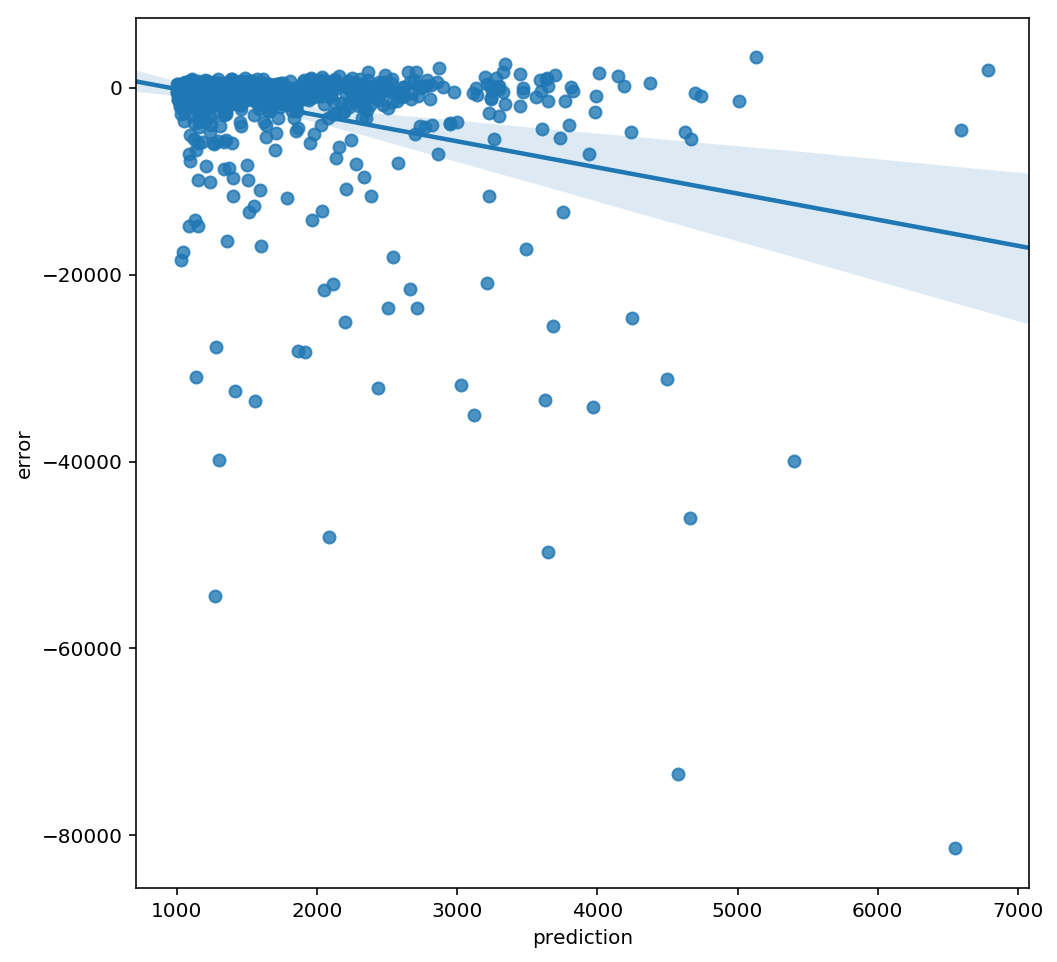

In [226]:
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(1, 1, 1)
data = df_preds[(df_preds["prediction"]>=1000)&(df_preds["prediction"]<=20000)]
sns.regplot(x='prediction',y='error',data=data.sample(1000),ax=ax)

(1000.0, 9276.310546875)


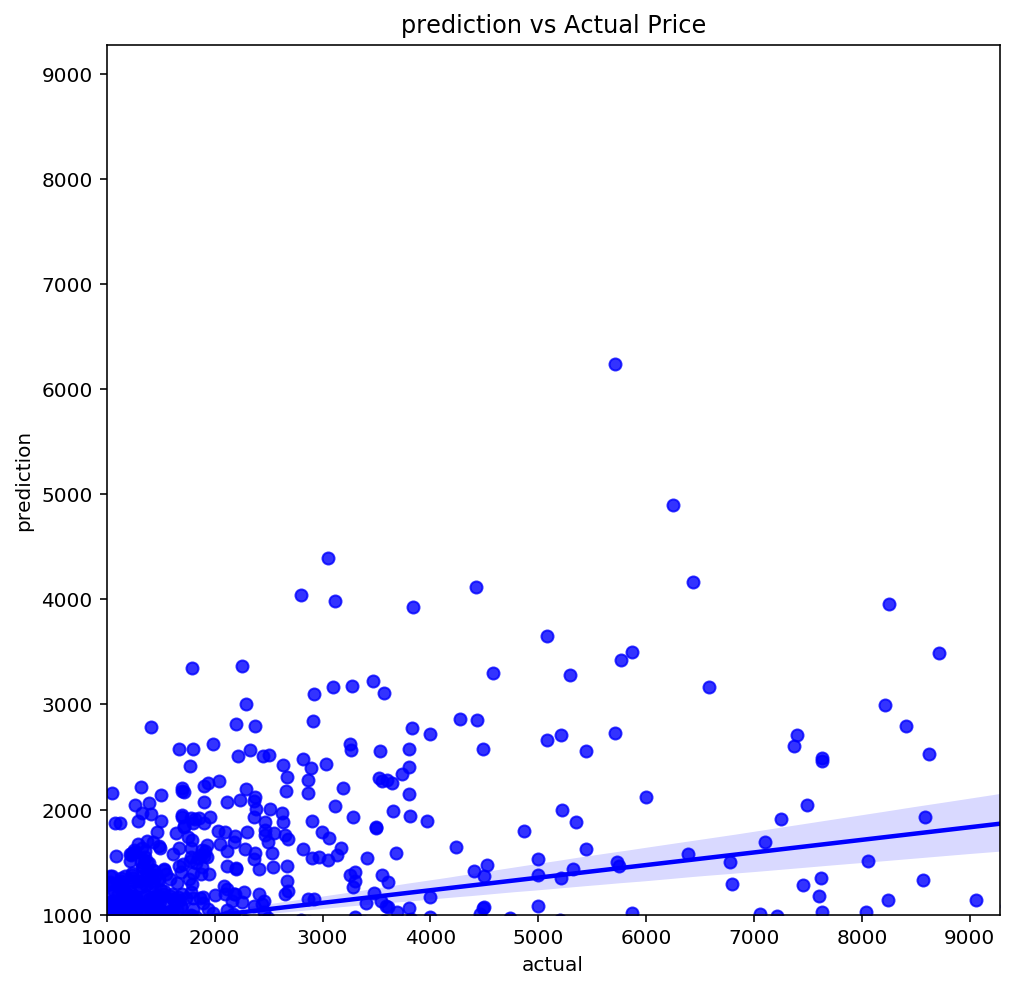

In [257]:
def actual_vs_other_column(column,actual_range):

    fig = plt.figure(figsize=(8,8));
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("%s vs Actual Price"%(column))
    rng = actual_range
    data = df_preds[(df_preds["actual"]>=rng[0])&(df_preds["actual"]<=rng[1])]
    plot_range = (data[['actual',column]].min().max(),data[['actual',column]].max().min())
    print(plot_range)
    sns.regplot(x="actual", y=column, data=data.sample(1000), color="b", ax = ax,fit_reg=True);
    plt.xlim(plot_range)
    plt.ylim(plot_range)
    plt.show()
actual_vs_other_column('prediction',(1000,10000))

In [311]:
df_preds.groupby(["GL"])[["actual","prediction"]].agg(['mean']).sample(10)

,actual,prediction
,mean,mean
GL,,
gl_musical_instruments,5171.146724,715.133362
gl_value_added_services,635.590000,367.704071
gl_sports_memorabilia,603.917278,402.404510
gl_jewelry,1297.509825,490.066193
gl_luxury_beauty,2306.180791,1297.581177
gl_grocery,471.721328,244.410095
gl_sdp_misc,2222.804594,497.403198
gl_toy,1230.344672,463.639679


# Observations and Suggestion for Improvements

## Observations

- Combining Pretrained embeddings with Trained Embeddings helped.
- Resnet Architecture Skip Connections boost performance (Vanishing Gradients).
- Saving Intermediate preprocessing steps helped in gaining speed.
- P3.8x Large Sagemaker Instance has multi-gpu (8 total), this needs separate Tensorflow sessions, I used separate notebooks
- Normalizing word vectors for Pretrained model was lowering performance, word vector lengths matter when you consider Text classification tasks, for NLP tasks like similarity they don't since cosine distance is used.
- The Process of using Word CNNs is easily carried over to Sub-categories Classification
- Why Ensembling Did not work?
    - Models with dropouts are like ensembles themselves
    - Only significant architecture or preprocessing step difference will help
- Why Char CNN did not work?
    - Long training time and huge number of computations
- Think about using a Non CNN deep network.
    - Process 1: Tf-Idf: 50k words -> 256x256 inner layer: 13 Million Params, No concept of sequence of words
    - Average Pretrained embeddings (300x256 + 256x256)= 140k params, No concept of sequence of words (Haven't tried)
    - LSTM/RNN: May perform better since handles sequences.


## Improvements

- **Improving Word Embeddings**
    - Use Bigger Vocab (I trimmed at 50k to keep computational cost down)
    - Fasttext or Bert/Elmo Models for text representation.
    - Try word-prices as additional input sequence.
- **Target Variable**
    - Training with Log/CubeRoot/Standard Scaling of target since target is skewed.
    - Bucketing/Quantizing: Dividing prices into cube-rooted buckets and then feeding the top 10 bucket prediction to final model.

- **Other Suggestions**
    - Inspecting Errors and finding text patterns we missed
    

In [305]:
# Competition Architecture
# ======== Using MSE as the Error Fn ==========
# MSE = 14706004.62, MAPE = 77.08, MEDAPE = 48.70
# MSE = 14646295.58, MAPE = 84.37, MEDAPE = 44.54
# MSE = 14438024.00, MAPE = 88.92, MEDAPE = 46.23

# ======= Using MAPE as the Error Fn ==========
# MSE = 19208402.34, MAPE = 35.03, MEDAPE = 27.54
# MSE = 19170641.31, MAPE = 34.86, MEDAPE = 27.29